# Copper price predictor (Demo)
* In this notebook, I will try to model prices of copper ore with the yearly production in the unit of AUD per tonne.
* I will be using LSTM to build a DL model to capture long-term trends properly.
* Recent years in Australia, have seen expectional growth in mining outputs and hence simpler models like ARIMA might not be suitable for default time series.
* Later I will also explore the impacts of using transformations before modelling performance.

In [141]:
import os
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_breuschpagan

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

from LSTM.model import *
from LSTM.dataset import *
from LSTM.evaluate import *

from utils.plot_utils import *
from utils.time_utils import *

In [142]:
os.listdir('./sample_data/')

['Aust-Mine-Prod-v01.4b-Tab08-Graph-Silver.pdf',
 'Aust-Mine-Prod-v01.4b-Tab06-Graph-Gold.pdf',
 'Aust-Mine-Prod-v01.4b-Tab09-Graph-Lead.pdf',
 'Aust-Mine-Prod-v01.4b-Tab07-Graph-Copper.pdf',
 'Aust-Mine-Prod-v01.4b-Tab05-Sn-Fields.csv',
 'Aust-Mine-Prod-v01.4b-Tab11-Graph-Nickel.pdf',
 'Aust-Mine-Prod-v01.4b-Tab10-Graph-Zinc.pdf',
 'Aust-Mine-Prod-v01.4b-Master.xlsx',
 'Aust-Mine-Prod-v01.4b-Tab04-Annual-Data.csv',
 'Aust-Mine-Prod-v01.4b-Tab06-11-Graphs.pptx',
 'Aust-Mine-Prod-v01.4b-Tab03-Mine-by-Mine.csv',
 'Aust-Mine-Prod-v01.4b-Tab01-Notes.csv',
 'Aust-Mine-Prod-v01.4b-Tab02-Summary.csv']

## Copper production data
Source: A Comprehensive dataset for Australian mine production 1799 to 2021 
(https://www.nature.com/articles/s41597-023-02275-z#Sec3)

License: Creative Commons Attribution 4.0 International (CC BY 4.0). Free to share, copy, redistribute, adapt, and build upon the data, even for commercial purposes, as long as appropriate credit is given to the original authors.

In [143]:
## Read the data
cu_cols = [0] + list(range(59,68))
cu_df = pd.read_csv('./sample_data/Aust-Mine-Prod-v01.4b-Tab04-Annual-Data.csv', skiprows=7, usecols=cu_cols)

## define dataframe headers
cu_header = cu_df.iloc[[0,1]].apply(lambda x: '_'.join(x.dropna().astype(str)), axis=0).to_list()
cu_header = [column.lower().replace(' ', '_').replace('.', '') for column in cu_header]
cu_df = cu_df.drop(index=[0,1]).reset_index(drop=True)
cu_df.columns = cu_header
cu_df.rename(columns={'australia_$/t_cu':'price_t'}, inplace=True)

## typecasting to floats
cu_df = cu_df.apply(lambda x: pd.to_numeric(x.astype(str).str.replace(',', ''), errors='coerce'))

## set year as the new index
cu_df.set_index(keys=['year'], inplace=True)

## handling missing values
cu_df.dropna(how="all", inplace=True)
cu_df.ffill(inplace=True) # forward-fill for the years where older values are available
cu_df.fillna(0, inplace=True) # zeroes for years before the first recorded value
cu_df.head(3)

,qld_t_cu,nsw_t_cu,vic_t_cu,tas_t_cu,sa_t_cu,wa_t_cu,nt_t_cu,australia_t_cu,price_t
year,,,,,,,,,
1842,0.0,0.0,0.0,0.0,2.03,0.0,0.0,2.03,101.38
1843,0.0,0.0,0.0,0.0,1.02,0.0,0.0,1.02,250.00
1844,0.0,0.0,0.0,0.0,55.90,0.0,0.0,55.90,143.16


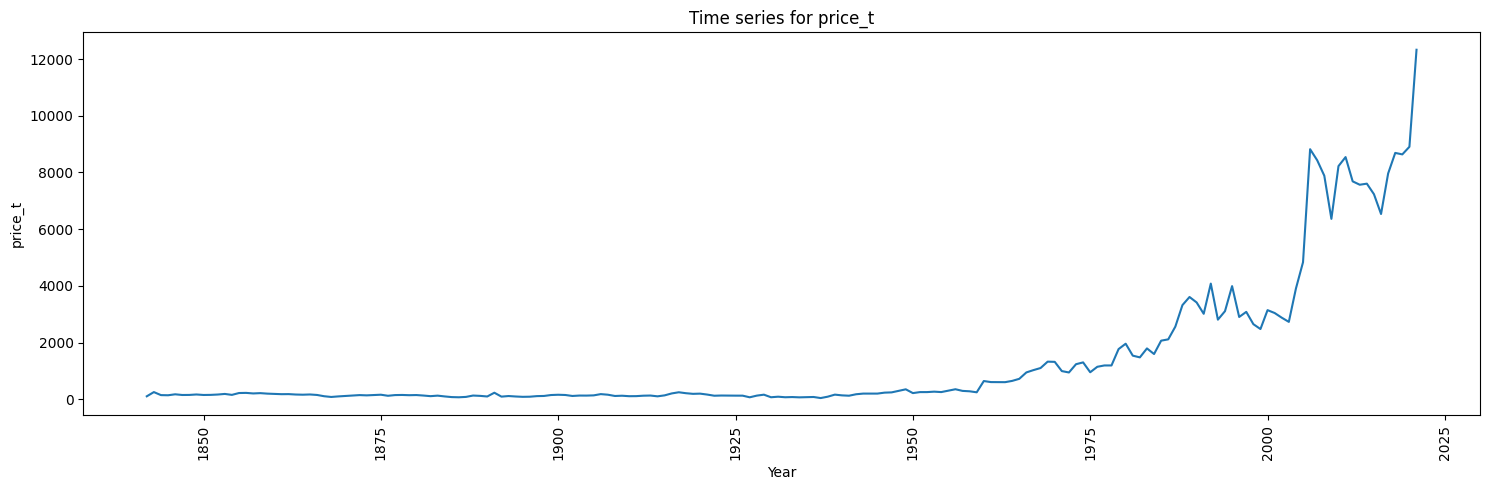

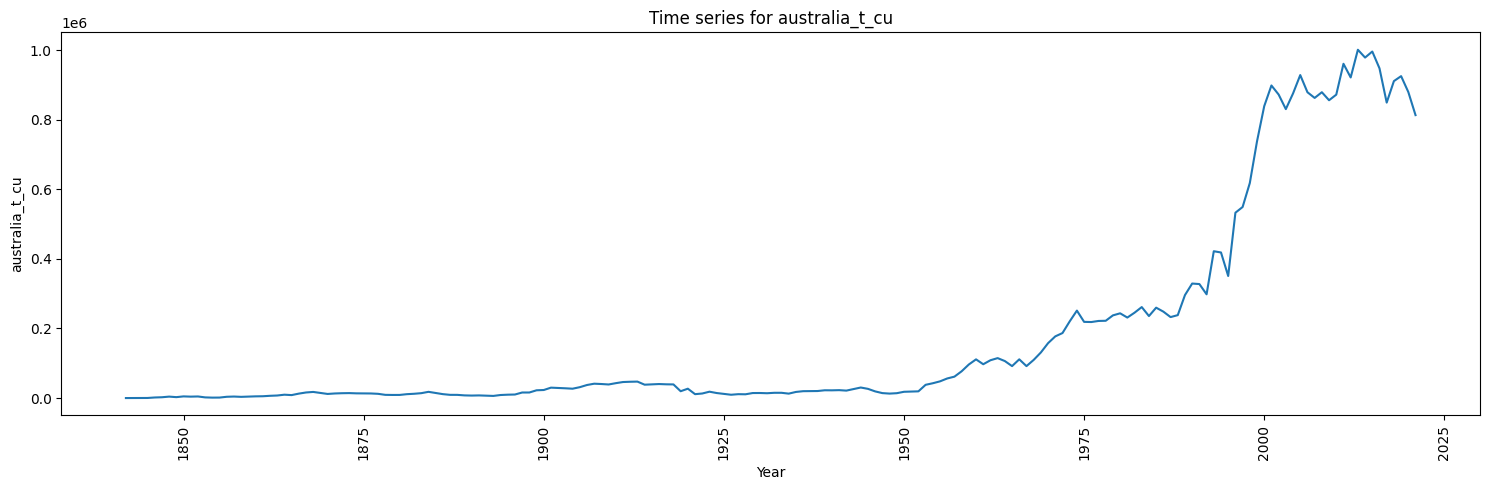

In [144]:
plot_time_series(cu_df, "price_t")
plot_time_series(cu_df, "australia_t_cu")

In [145]:
# apply transformations
price_transformed, price_lambda, price_shift = boxcox_transform(cu_df['price_t'])
prod_transformed, prod_lambda, prod_shift = boxcox_transform(cu_df['australia_t_cu'])
print(f'Transformed Price Box-Cox Lambda: {price_lambda}, Shift: {price_shift}')
print(f'Transformed Production Box-Cox Lambda: {prod_lambda}, Shift: {prod_shift}')
cu_df.loc[:, ['price_t_transformed']] = price_transformed
cu_df.loc[:, ['australia_t_cu_transformed']] = prod_transformed

Transformed Price Box-Cox Lambda: -0.4003176891074204, Shift: 0
Transformed Production Box-Cox Lambda: 0.09433617745909952, Shift: 0


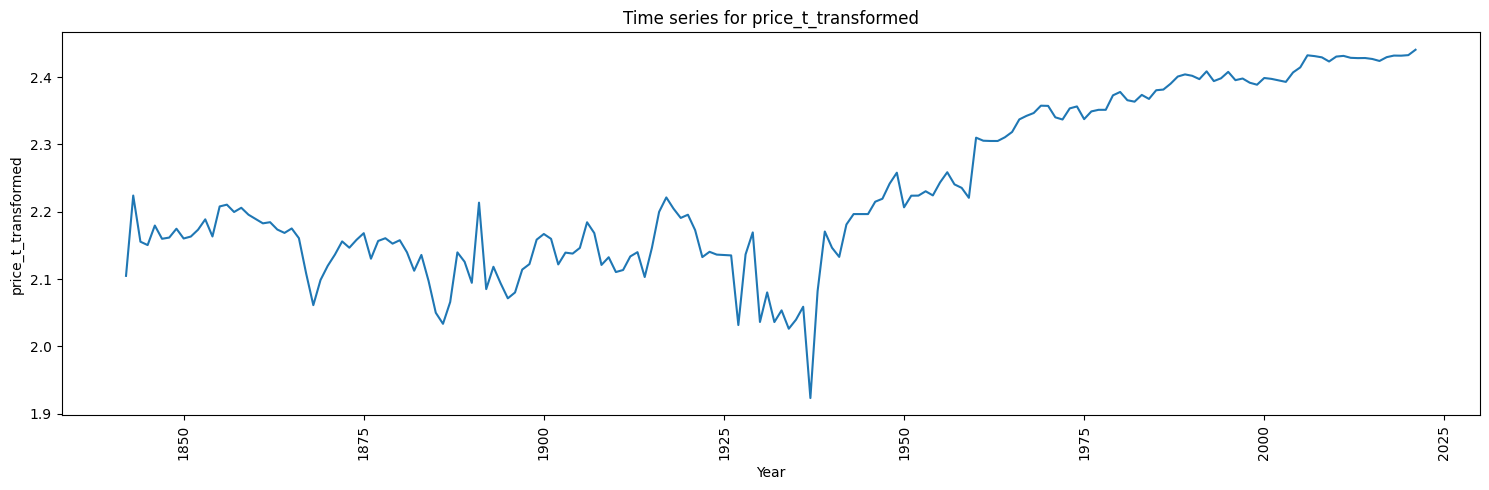

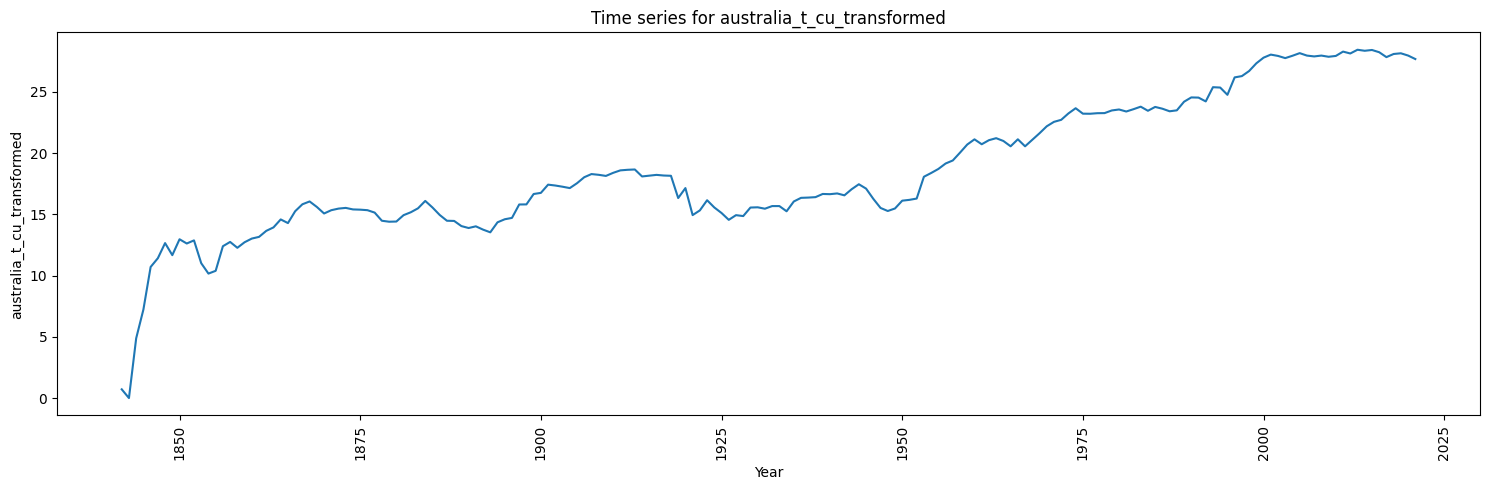

In [146]:
plot_time_series(cu_df, "price_t_transformed")
plot_time_series(cu_df, "australia_t_cu_transformed")

In [147]:
cu_df.loc[:, ['log_price_t']] = np.log(cu_df['price_t'])
cu_df.loc[:, ['log_australia_t_cu']] = np.log(cu_df['australia_t_cu'])

cu_df.loc[:, ['log_price_t_last']] = cu_df['log_price_t'].shift(1)
cu_df.loc[:, ['log_australia_t_cu_last']] = cu_df['log_australia_t_cu'].shift(1)

cu_df.loc[:, ['log_diff_price_t']] = cu_df['log_price_t'] - cu_df['log_price_t_last']
cu_df.loc[:, ['log_diff_australia_t_cu']] = cu_df['log_australia_t_cu'] - cu_df['log_australia_t_cu_last']

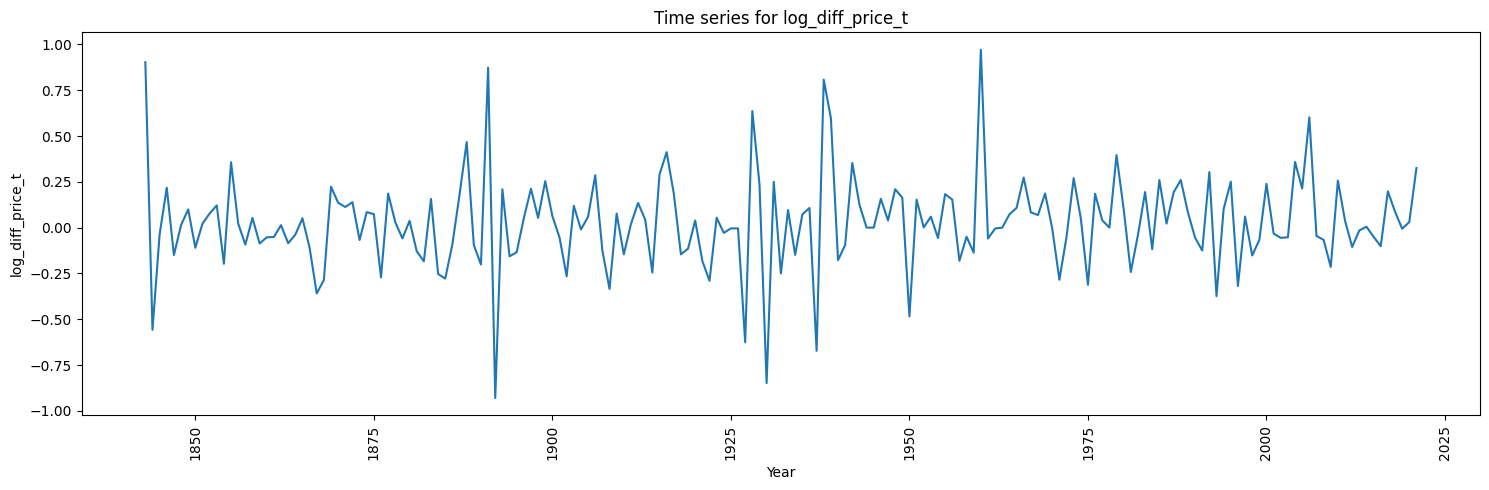

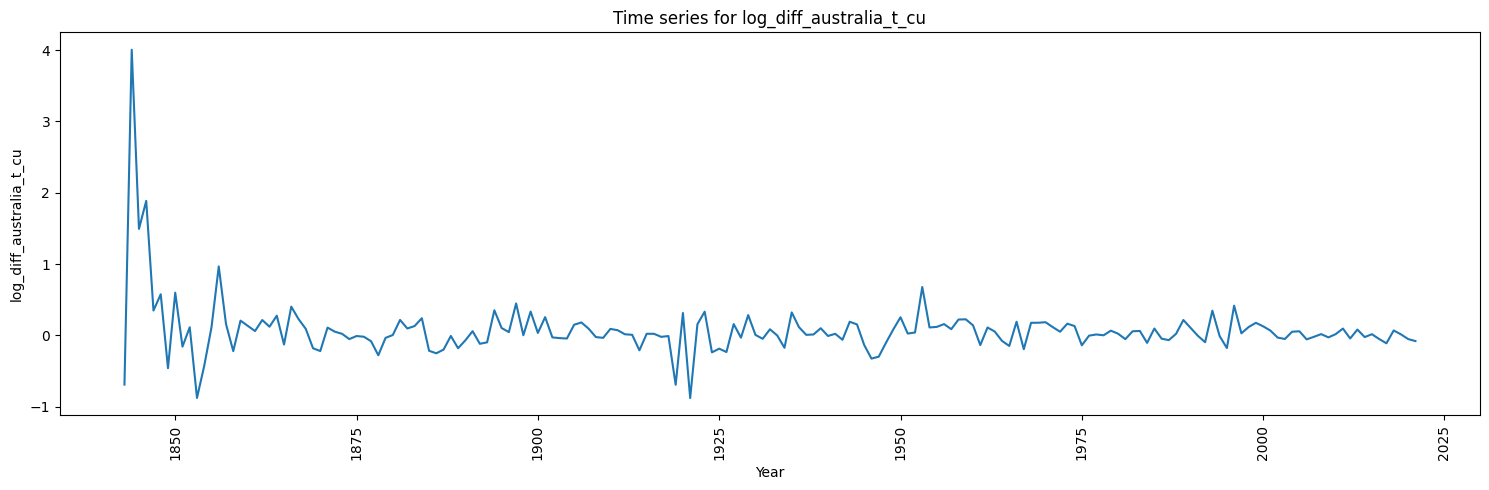

In [148]:
plot_time_series(cu_df, "log_diff_price_t")
plot_time_series(cu_df, "log_diff_australia_t_cu")

In [149]:
# add a few lag features
cu_df['au_t_cu_lag3'] = cu_df['australia_t_cu'].shift(3)
cu_df['au_t_cu_lag5'] = cu_df['australia_t_cu'].shift(5)
cu_df['au_t_cu_lag7'] = cu_df['australia_t_cu'].shift(7)

In [150]:
cu_df.isna().sum()

qld_t_cu                      0
nsw_t_cu                      0
vic_t_cu                      0
tas_t_cu                      0
sa_t_cu                       0
wa_t_cu                       0
nt_t_cu                       0
australia_t_cu                0
price_t                       0
price_t_transformed           0
australia_t_cu_transformed    0
log_price_t                   0
log_australia_t_cu            0
log_price_t_last              1
log_australia_t_cu_last       1
log_diff_price_t              1
log_diff_australia_t_cu       1
au_t_cu_lag3                  3
au_t_cu_lag5                  5
au_t_cu_lag7                  7
dtype: int64

## Modelling
Let's try to model the price of the copper (per tonne) on the supply factors namely the per year production for the copper in Australia. We will try to test if there is observable relation between overall sales in Australia and price of copper. If so, we will uncover any linear correlation between the two variables.

In [151]:
# defining training and testing data
train_start_year, train_end_year = 1850, 2010

train_df = cu_df.loc[train_start_year:train_end_year, ]
test_df = cu_df.loc[train_end_year:, ]
print(f"Training dataset: {train_df.shape}")
print(f"Testing dataset: {test_df.shape}")

Training dataset: (161, 20)
Testing dataset: (12, 20)


In [152]:
train_df.isna().sum()

qld_t_cu                      0
nsw_t_cu                      0
vic_t_cu                      0
tas_t_cu                      0
sa_t_cu                       0
wa_t_cu                       0
nt_t_cu                       0
australia_t_cu                0
price_t                       0
price_t_transformed           0
australia_t_cu_transformed    0
log_price_t                   0
log_australia_t_cu            0
log_price_t_last              0
log_australia_t_cu_last       0
log_diff_price_t              0
log_diff_australia_t_cu       0
au_t_cu_lag3                  0
au_t_cu_lag5                  0
au_t_cu_lag7                  0
dtype: int64

In [153]:
train_df.tail(3)

,qld_t_cu,nsw_t_cu,vic_t_cu,tas_t_cu,sa_t_cu,wa_t_cu,nt_t_cu,australia_t_cu,price_t,price_t_transformed,australia_t_cu_transformed,log_price_t,log_australia_t_cu,log_price_t_last,log_australia_t_cu_last,log_diff_price_t,log_diff_australia_t_cu,au_t_cu_lag3,au_t_cu_lag5,au_t_cu_lag7
year,,,,,,,,,,,,,,,,,,,,
2008,381029.0,146036.0,1000.0,27749.0,196080.0,126225.0,11800.0,878940.0,7886.0,2.429212,27.952075,8.972844,13.686472,9.039671,13.667631,-0.066826,0.018841,928217.0,830388.0,898342.0
2009,269373.0,161448.0,1000.0,27339.0,251932.0,145400.0,11800.0,855892.0,6364.0,2.423045,27.855555,8.758412,13.659899,8.972844,13.686472,-0.214432,-0.026572,878874.0,875376.0,872281.0
2010,279554.0,149090.0,1000.0,28517.0,246056.0,168746.0,11800.0,871963.0,8225.0,2.430361,27.923101,9.014934,13.678502,8.758412,13.659899,0.256521,0.018603,862535.0,928217.0,830388.0


#### Augmented Dickey-Fuller (ADF) test for stationarity
##### If the p-value < 0.05, stationary exisits. A more negative value suggests stronger evidence against the null hypothesis.

In [154]:
test_stationarity(train_df['price_t'], 'Price')
test_stationarity(train_df['australia_t_cu'], 'Production')


ADF Statistic for Price: 6.11607155282393
p-value for Price: 1.0
Critical Value (1%): -3.4759527332353084
Critical Value (5%): -2.881548071241103
Critical Value (10%): -2.577438765246763
The Price series is non-stationary.

ADF Statistic for Production: 4.29672083918795
p-value for Production: 1.0
Critical Value (1%): -3.4759527332353084
Critical Value (5%): -2.881548071241103
Critical Value (10%): -2.577438765246763
The Production series is non-stationary.


In [155]:
test_stationarity(train_df['price_t_transformed'], 'Transformed Price')
test_stationarity(train_df['australia_t_cu_transformed'], 'Transformed Production')


ADF Statistic for Transformed Price: -0.42249329870243196
p-value for Transformed Price: 0.9062749205210335
Critical Value (1%): -3.4724305215713156
Critical Value (5%): -2.8800127935315465
Critical Value (10%): -2.576619230892485
The Transformed Price series is non-stationary.

ADF Statistic for Transformed Production: 0.2478026341435243
p-value for Transformed Production: 0.9748188010439893
Critical Value (1%): -3.4718957209472654
Critical Value (5%): -2.8797795410156253
Critical Value (10%): -2.5764947265625
The Transformed Production series is non-stationary.


In [156]:
test_stationarity(train_df['log_diff_price_t'], 'Log differenced Price')
test_stationarity(train_df['log_diff_australia_t_cu'], 'Log differenced Production')


ADF Statistic for Log differenced Price: -11.923188870538272
p-value for Log differenced Price: 4.976620895507766e-22
Critical Value (1%): -3.472161410886292
Critical Value (5%): -2.8798954259680936
Critical Value (10%): -2.5765565828092245
The Log differenced Price series is stationary.

ADF Statistic for Log differenced Production: -8.515231509022035
p-value for Log differenced Production: 1.1388180467019989e-13
Critical Value (1%): -3.472161410886292
Critical Value (5%): -2.8798954259680936
Critical Value (10%): -2.5765565828092245
The Log differenced Production series is stationary.


#### Breusch-Pagan (BP) test for heteroscedasticity

##### If the p-value < 0.05, heteroscedasticity exists. It relates to constant variance in the errors over time.


Breusch-Pagan Test Results:
LM Statistic: 102.60129330540686
LM Test p-value: 4.098656710322489e-24
F-Statistic: 279.34874860970325
F-Test p-value: 7.643152898490572e-37
Residuals are heteroscedastic.


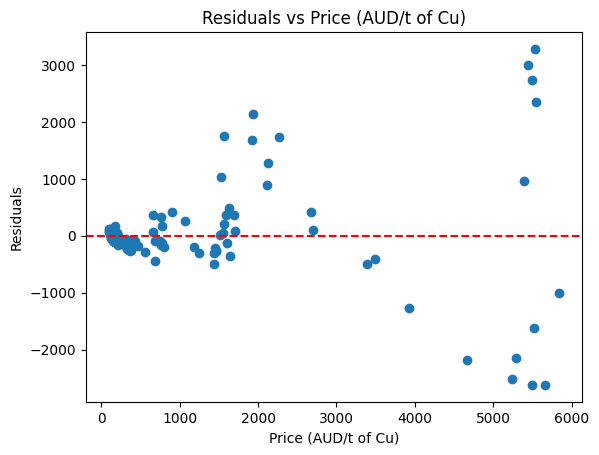

In [157]:
X = sm.add_constant(train_df['australia_t_cu'])
y = train_df['price_t']
residuals = test_homoscedasticity(y, X)

plot_residuals_vs_fitted(y, residuals, "Price (AUD/t of Cu)")


Breusch-Pagan Test Results:
LM Statistic: 15.335880469968165
LM Test p-value: 8.999096662015578e-05
F-Statistic: 16.739915104640485
F-Test p-value: 6.797143456401854e-05
Residuals are heteroscedastic.


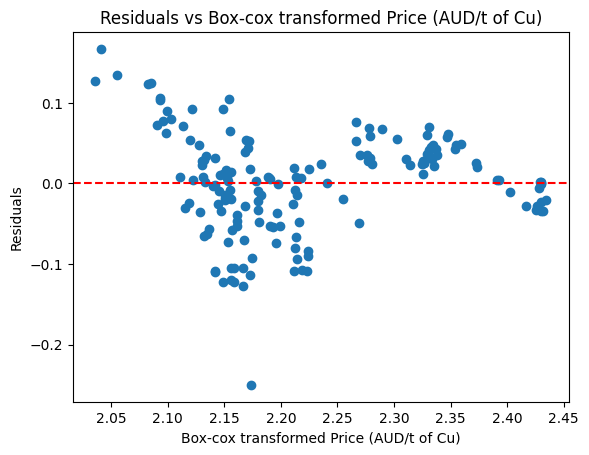

In [158]:
X_transformed = sm.add_constant(train_df['australia_t_cu_transformed'])
y_transformed = train_df['price_t_transformed']
residuals_transformed = test_homoscedasticity(y_transformed, X_transformed)

plot_residuals_vs_fitted(y_transformed, residuals_transformed, "Box-cox transformed Price (AUD/t of Cu)")


Breusch-Pagan Test Results:
LM Statistic: 0.010759860739581795
LM Test p-value: 0.9173838180451044
F-Statistic: 0.010626908084745179
F-Test p-value: 0.9180239093814637
Residuals are homoscedastic.


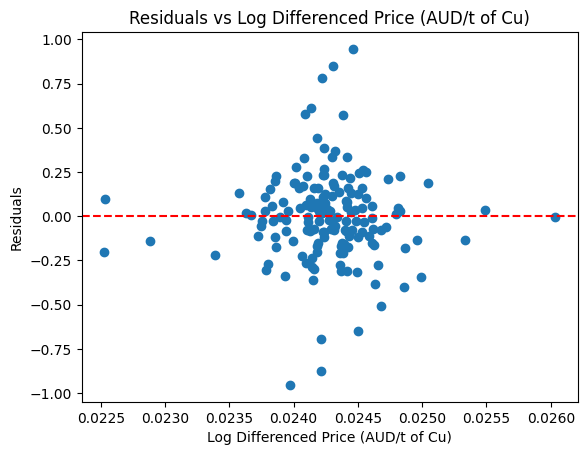

In [159]:
X_transformed = sm.add_constant(train_df['log_diff_australia_t_cu'])
y_transformed = train_df['log_diff_price_t']
residuals_transformed = test_homoscedasticity(y_transformed, X_transformed)

plot_residuals_vs_fitted(y_transformed, residuals_transformed, "Log Differenced Price (AUD/t of Cu)")

Log differenced time series are observed to be stationary and homoscedastic. It tells us that it would be beneficial to produce a model on changes in time series instead of actual values. Let's experiment with the following setup to validate thinking:
1. Price on Production (across whole Australia)
2. Price on Production (across different states in Australia)
3. Price on Production (acros whole Australia) & its lagged values
4. Changes in price on changes in production (across whole Australia)

#### a. Price on Production (Australia)

In [160]:
train_cols=['australia_t_cu']
target_col=['price_t']

feat_scaler=MinMaxScaler()
target_scaler=MinMaxScaler()

X_train_tensor, y_train_tensor, feat_scaler, target_scaler = prepare_train_data(
    df=train_df,
    feat_cols=train_cols,
    target_col=target_col,
    feat_scaler=feat_scaler,
    target_scaler=target_scaler,
    seq_length=5
)

X_test_tensor, y_test_tensor = prepare_test_data(
    df=test_df,
    feat_cols=train_cols,
    target_col=target_col,
    feat_scaler=feat_scaler,
    target_scaler=target_scaler,
    seq_length=5,
    scale_target=False
)

print(X_train_tensor.shape, y_train_tensor.shape)
print(X_test_tensor.shape, y_test_tensor.shape)

torch.Size([156, 5, 1]) torch.Size([156, 1])
torch.Size([7, 5, 1]) torch.Size([7, 1])


In [161]:
input_size = X_train_tensor.shape[2]  # Number of production features (columns)
hidden_size = 64  # Number of LSTM units
output_size = 1   # Predicting price
num_layers = 2   # Number of LSTM layers

simple_model = LSTMModel(input_size, hidden_size, output_size, num_layers)
print(simple_model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.0001)

num_epochs = 200
for epoch in range(num_epochs):
    simple_model.train()
    
    # Forward pass
    outputs = simple_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Epoch [10/200], Loss: 0.0692
Epoch [20/200], Loss: 0.0626
Epoch [30/200], Loss: 0.0566
Epoch [40/200], Loss: 0.0512
Epoch [50/200], Loss: 0.0462
Epoch [60/200], Loss: 0.0419
Epoch [70/200], Loss: 0.0383
Epoch [80/200], Loss: 0.0356
Epoch [90/200], Loss: 0.0337
Epoch [100/200], Loss: 0.0325
Epoch [110/200], Loss: 0.0318
Epoch [120/200], Loss: 0.0311
Epoch [130/200], Loss: 0.0305
Epoch [140/200], Loss: 0.0298
Epoch [150/200], Loss: 0.0291
Epoch [160/200], Loss: 0.0283
Epoch [170/200], Loss: 0.0275
Epoch [180/200], Loss: 0.0265
Epoch [190/200], Loss: 0.0254
Epoch [200/200], Loss: 0.0242


Mean Squared Error (MSE): 1857886.75
Root mean Squared Error (MSE): 1363.043212890625


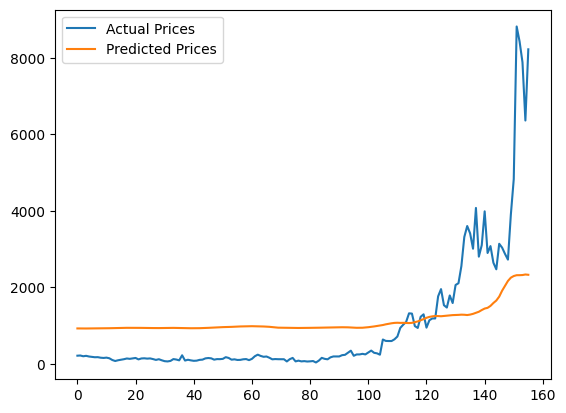

In [162]:
mse_a, rmse_a = evaluate_model(model=simple_model,
        feature_tensor=X_train_tensor,
        target_tensor=y_train_tensor,
        target_scaler=target_scaler
)

#### b. Price on Production (States in Australia)

In [163]:
train_cols=[ 'qld_t_cu', 'nsw_t_cu', 'vic_t_cu', 'tas_t_cu', 'sa_t_cu', 'wa_t_cu', 'nt_t_cu']
target_col=['price_t']

feat_scaler=MinMaxScaler()
target_scaler=MinMaxScaler()

X_train_tensor, y_train_tensor, feat_scaler, target_scaler = prepare_train_data(
    df=train_df,
    feat_cols=train_cols,
    target_col=target_col,
    feat_scaler=feat_scaler,
    target_scaler=target_scaler,
    seq_length=5
)

X_test_tensor, y_test_tensor = prepare_test_data(
    df=test_df,
    feat_cols=train_cols,
    target_col=target_col,
    feat_scaler=feat_scaler,
    target_scaler=target_scaler,
    seq_length=5,
    scale_target=False
)

print(X_train_tensor.shape, y_train_tensor.shape)
print(X_test_tensor.shape, y_test_tensor.shape)

torch.Size([156, 5, 7]) torch.Size([156, 1])
torch.Size([7, 5, 7]) torch.Size([7, 1])


In [164]:
input_size = X_train_tensor.shape[2]  # Number of production features (columns)
hidden_size = 64  # Number of LSTM units
output_size = 1   # Predicting price
num_layers = 2   # Number of LSTM layers

# device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
simple_model = LSTMModel(input_size, hidden_size, output_size, num_layers)
print(simple_model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.0001)

num_epochs = 200
for epoch in range(num_epochs):
    simple_model.train()
    
    # Forward pass
    outputs = simple_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

LSTMModel(
  (lstm): LSTM(7, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Epoch [10/200], Loss: 0.0498
Epoch [20/200], Loss: 0.0446
Epoch [30/200], Loss: 0.0400
Epoch [40/200], Loss: 0.0360
Epoch [50/200], Loss: 0.0327
Epoch [60/200], Loss: 0.0299
Epoch [70/200], Loss: 0.0277
Epoch [80/200], Loss: 0.0258
Epoch [90/200], Loss: 0.0240
Epoch [100/200], Loss: 0.0221
Epoch [110/200], Loss: 0.0200
Epoch [120/200], Loss: 0.0178
Epoch [130/200], Loss: 0.0154
Epoch [140/200], Loss: 0.0129
Epoch [150/200], Loss: 0.0105
Epoch [160/200], Loss: 0.0084
Epoch [170/200], Loss: 0.0068
Epoch [180/200], Loss: 0.0058
Epoch [190/200], Loss: 0.0053
Epoch [200/200], Loss: 0.0051


Mean Squared Error (MSE): 393056.0625
Root mean Squared Error (MSE): 626.9418334960938


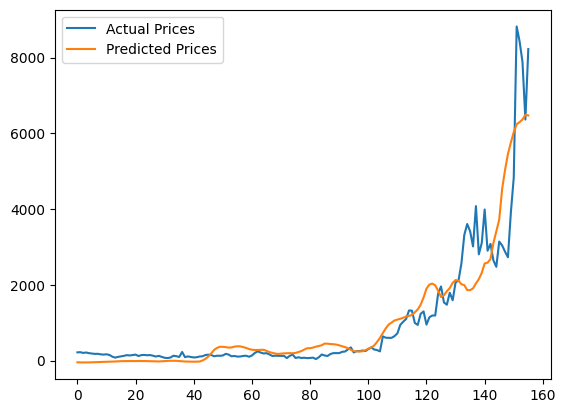

In [165]:
mse_b, rmse_b = evaluate_model(model=simple_model,
        feature_tensor=X_train_tensor,
        target_tensor=y_train_tensor,
        target_scaler=target_scaler
)

The Mean squared error (MSE) have dropped by a third compared to when the model was trained only on single variable of country-wide production of copper.

#### c. Price on Production (Australia) with lags

In [166]:
train_cols=['australia_t_cu', 'au_t_cu_lag3', 'au_t_cu_lag5', 'au_t_cu_lag7']
target_col=['price_t']

feat_scaler=MinMaxScaler()
target_scaler=MinMaxScaler()

X_train_tensor, y_train_tensor, feat_scaler, target_scaler = prepare_train_data(
    df=train_df,
    feat_cols=train_cols,
    target_col=target_col,
    feat_scaler=feat_scaler,
    target_scaler=target_scaler,
    seq_length=5
)

X_test_tensor, y_test_tensor = prepare_test_data(
    df=test_df,
    feat_cols=train_cols,
    target_col=target_col,
    feat_scaler=feat_scaler,
    target_scaler=target_scaler,
    seq_length=5,
    scale_target=False
)

print(X_train_tensor.shape, y_train_tensor.shape)
print(X_test_tensor.shape, y_test_tensor.shape)

torch.Size([156, 5, 4]) torch.Size([156, 1])
torch.Size([7, 5, 4]) torch.Size([7, 1])


In [167]:
input_size = X_train_tensor.shape[2]  # Number of production features (columns)
hidden_size = 64  # Number of LSTM units
output_size = 1   # Predicting price
num_layers = 2   # Number of LSTM layers

simple_model = LSTMModel(input_size, hidden_size, output_size, num_layers)
print(simple_model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.0001)

num_epochs = 200
for epoch in range(num_epochs):
    simple_model.train()
    
    # Forward pass
    outputs = simple_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

LSTMModel(
  (lstm): LSTM(4, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Epoch [10/200], Loss: 0.0460
Epoch [20/200], Loss: 0.0422
Epoch [30/200], Loss: 0.0391
Epoch [40/200], Loss: 0.0366
Epoch [50/200], Loss: 0.0346
Epoch [60/200], Loss: 0.0330
Epoch [70/200], Loss: 0.0316
Epoch [80/200], Loss: 0.0303
Epoch [90/200], Loss: 0.0289
Epoch [100/200], Loss: 0.0274
Epoch [110/200], Loss: 0.0255
Epoch [120/200], Loss: 0.0233
Epoch [130/200], Loss: 0.0208
Epoch [140/200], Loss: 0.0178
Epoch [150/200], Loss: 0.0144
Epoch [160/200], Loss: 0.0109
Epoch [170/200], Loss: 0.0076
Epoch [180/200], Loss: 0.0052
Epoch [190/200], Loss: 0.0040
Epoch [200/200], Loss: 0.0037


Mean Squared Error (MSE): 282925.0625
Root mean Squared Error (MSE): 531.906982421875


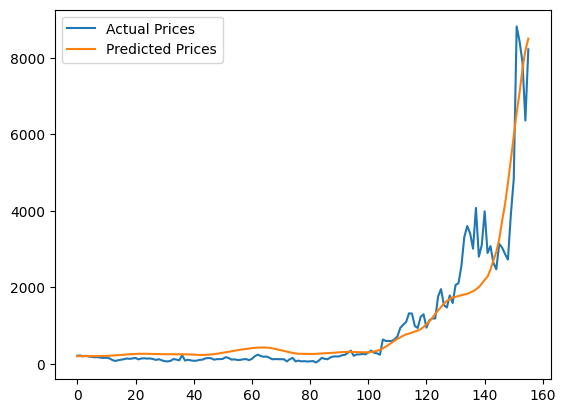

In [168]:
mse_c, rmse_c = evaluate_model(model=simple_model,
        feature_tensor=X_train_tensor,
        target_tensor=y_train_tensor,
        target_scaler=target_scaler
)

In [169]:
print(f"Percentage change in MSE from a. to b.: {np.round(((mse_b-mse_a)/mse_a)*100, 2)}%")
print(f"Percentage change in MSE from b. to c.: {np.round(((mse_c-mse_b)/mse_b)*100, 2)}%")

Percentage change in MSE from a. to b.: -78.84%
Percentage change in MSE from b. to c.: -28.02%


#### d. Production changes vs Price changes (Australia)

In [170]:
train_cols=['log_diff_australia_t_cu']
target_col=['log_diff_price_t']

feat_scaler=MinMaxScaler()
target_scaler=MinMaxScaler()

X_train_tensor, y_train_tensor, feat_scaler, target_scaler = prepare_train_data(
    df=train_df,
    feat_cols=train_cols,
    target_col=target_col,
    feat_scaler=feat_scaler,
    target_scaler=target_scaler,
    seq_length=5
)

X_test_tensor, y_test_tensor = prepare_test_data(
    df=test_df,
    feat_cols=train_cols,
    target_col=target_col,
    feat_scaler=feat_scaler,
    target_scaler=target_scaler,
    seq_length=5,
    scale_target=False
)

print(X_train_tensor.shape, y_train_tensor.shape)
print(X_test_tensor.shape, y_test_tensor.shape)

torch.Size([156, 5, 1]) torch.Size([156, 1])
torch.Size([7, 5, 1]) torch.Size([7, 1])


In [171]:
input_size = X_train_tensor.shape[2]  # Number of production features (columns)
hidden_size = 64  # Number of LSTM units
output_size = 1   # Predicting price
num_layers = 2   # Number of LSTM layers

simple_model = LSTMModel(input_size, hidden_size, output_size, num_layers)
print(simple_model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.0001)

num_epochs = 200
for epoch in range(num_epochs):
    simple_model.train()
    
    # Forward pass
    outputs = simple_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Epoch [10/200], Loss: 0.2618
Epoch [20/200], Loss: 0.2411
Epoch [30/200], Loss: 0.2208
Epoch [40/200], Loss: 0.2006
Epoch [50/200], Loss: 0.1801
Epoch [60/200], Loss: 0.1590
Epoch [70/200], Loss: 0.1372
Epoch [80/200], Loss: 0.1147
Epoch [90/200], Loss: 0.0919
Epoch [100/200], Loss: 0.0695
Epoch [110/200], Loss: 0.0492
Epoch [120/200], Loss: 0.0331
Epoch [130/200], Loss: 0.0230
Epoch [140/200], Loss: 0.0192
Epoch [150/200], Loss: 0.0189
Epoch [160/200], Loss: 0.0190
Epoch [170/200], Loss: 0.0189
Epoch [180/200], Loss: 0.0189
Epoch [190/200], Loss: 0.0189
Epoch [200/200], Loss: 0.0189


Mean Squared Error (MSE): 206760.83370707402
Root mean Squared Error (MSE): 454.70961470709415


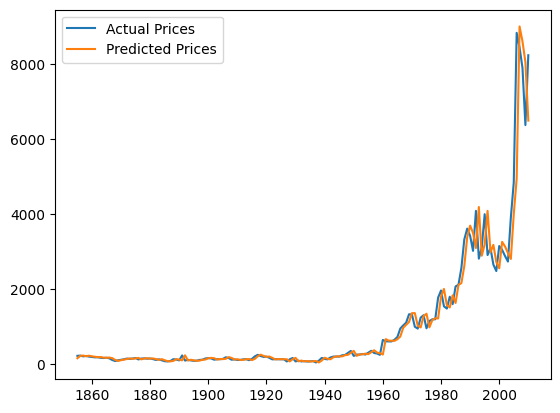

In [172]:
mse_d, rmse_d = evaluate_log_diff_model(model=simple_model,
    feature_tensor=X_train_tensor,
    target_tensor=y_train_tensor,
    target_scaler=target_scaler,
    df=train_df 
)

In [173]:
print(f"Percentage change in MSE from c. to d.: {np.round(((mse_d-mse_c)/mse_c)*100, 2)}%")
print(f"Percentage change in MSE from a. to d.: {np.round(((mse_d-mse_a)/mse_a)*100, 2)}%")

Percentage change in MSE from c. to d.: -26.92%
Percentage change in MSE from a. to d.: -88.87%


Overall we observe that log-differencing transformation has signficantly helped us reduce the target metric of Mean squared errors compared to using raw values of the time series. Let's check the model on the test (unseen) dataset.

### Evaluation on test dataset

Mean Squared Error (MSE): 1974043.1750163962
Root mean Squared Error (MSE): 1405.0064679624775


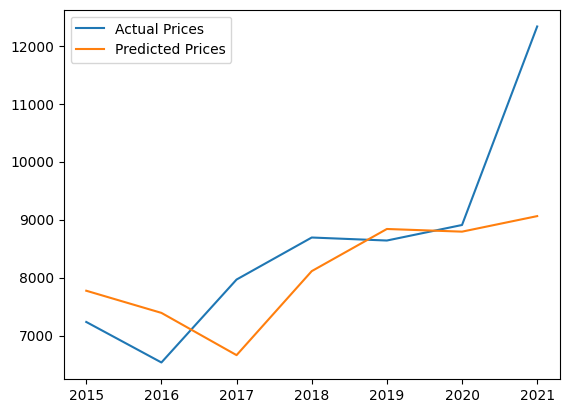

(1974043.18, 1405.01)

In [174]:
evaluate_log_diff_model(model=simple_model,
    feature_tensor=X_test_tensor,
    target_tensor=y_test_tensor,
    target_scaler=target_scaler,
    df=test_df )